## This notebook develops a classification model to determine the revenue class of a customer based on their monthly features.
The dataset contains information about customers, including the following features::
- reg_platform: The platform used for registration (website, mobile apps for different operating systems, landing pages).
- used_promo: Whether the customer used a promo code during registration.
- first_bet_sum: The amount of the first bet.
- m_win_cnt_bet: The number of winning bets during the month.
- m_lose_cnt_bet: The number of losing bets during the month.
- m_turnover: The total turnover for the month.
- m_revenue: The revenue generated for the month.
- m_sum_dep: The total sum of deposits made during the month.
- m_sum_out: The total sum of withdrawals made during the month.
- m_cnt_dep: The number of deposits made during the month.
- max_wins: The maximum number of consecutive winning bets.
- first_day: The day of the week when the first bet was placed.
- fbt_turnover: The ratio of the first bet amount to the monthly turnover.
- revenue_class: The customer's revenue class (target variable).
- revenue: The revenue generated over six months.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle


In [2]:
clients = pd.read_csv('20092023.csv')
st = pd.read_csv('wins_in_row_2023.csv')

st = st.rename(columns={"id_account": "id"})
df = pd.merge(clients, st, on="id")
df.head()

,uid,id,reg_platform,first_bet_date,used_promo,channel_final_name,revenue,first_bet_sum,m_win_cnt_bet,m_lose_cnt_bet,m_turnover,m_revenue,m_sum_dep,m_sum_out,m_cnt_dep,max_wins
0,1.000830e+10,211AWWZGS3ZVJ,IOS,2024-02-12 14:49:56,0,Отсутствует ICM,400.00,100.0,3.0,7.0,997.0,400.00,400.0,0.0,2.0,1
1,1.000737e+10,211EGWCH8OK6S,Site,2023-07-28 22:30:40,0,direct,-1588.00,500.0,7.0,4.0,7400.0,-1588.00,3000.0,0.0,1.0,3
2,1.000748e+10,211HN4YMIHB4J,MobileSite,2023-10-28 08:52:49,0,Отсутствует ICM,-4530.00,1300.0,3.0,2.0,5750.0,-4530.00,5000.0,9530.0,1.0,2
3,1.000833e+10,211KCDHPUUXRW,Android,2024-03-07 19:52:37,0,Отсутствует ICM,-885.83,115.0,2.0,6.0,668.0,-885.83,115.0,1000.0,1.0,1
4,1.000755e+10,211LE8B3PSPEW,MobileSite,2023-12-21 20:00:11,0,CPA,939.50,800.0,2.0,2.0,3850.0,939.50,3850.0,2910.0,4.0,1


In [18]:
df['first_bet_date'] = pd.to_datetime(df['first_bet_date'])
df.dtypes

uid                          float64
id                            object
reg_platform                  object
first_bet_date        datetime64[ns]
used_promo                     int64
channel_final_name            object
revenue                      float64
first_bet_sum                float64
m_win_cnt_bet                float64
m_lose_cnt_bet               float64
m_turnover                   float64
m_revenue                    float64
m_sum_dep                    float64
m_sum_out                    float64
m_cnt_dep                    float64
max_wins                       int64
dtype: object

In [19]:
# getting the day of the week on which the client performed the first action

df['first_day'] = df['first_bet_date'].dt.dayofweek

In [20]:
# clearing categorical data values

df['reg_platform'] = df['reg_platform'].str.replace('Windows', 'Site')

In [21]:
cfn = ['Отсутствует ICM', 'Тип ICM не указан', 'CPM', 'CPA', 'direct', 'organic', 'smm']

no_icm = "Отсутствует|нет в справочнике"
no_type = "не указан"
cpm = "CPM"
cpa = "CPA"
direct = "direct|Email|seo"
organic = "organic|other"
smm = "smm"

conditions = [
    (df['channel_final_name'].str.contains(no_icm)),
    (df['channel_final_name'].str.contains(no_type)),
    (df['channel_final_name'].str.contains(cpm)),
    (df['channel_final_name'].str.contains(cpa)),
    (df['channel_final_name'].str.contains(direct)),
    (df['channel_final_name'].str.contains(organic)),
    (df['channel_final_name'].str.contains(smm))
]

df['channel'] = np.select(conditions, cfn, default='other')

In [22]:
# dropping unnecessary columns

df = df.drop(columns=['channel_final_name', 'uid', 'id', 'first_bet_date'])

In [23]:
# creating new feature

df['fbt_turnover'] = df['m_turnover'] / df['first_bet_sum']

In [24]:
# creating revenue bins based on the distribution of values that we studied in the EDA notebook: 

df['revenue_class'] = pd.cut(df['revenue'], bins=[-float('inf'), 0, 10000, 50000, float('inf')], labels=[0, 1, 2, 3])

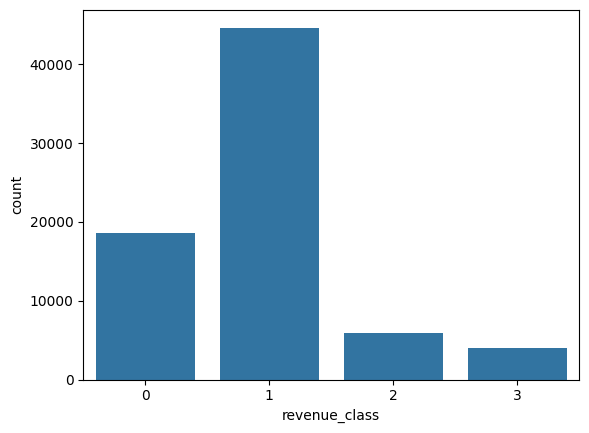

In [25]:
# Using a histogram, checking the number of clients in each class.

sns.countplot(data = df, x='revenue_class')
plt.show()

Applying winsorization - a technique where we cap the extreme values in the data at a certain percentile, which helps to reduce the influence of outliers without removing them. 


In [26]:
columns_to_winsorize = ['revenue']

for col in columns_to_winsorize:
    # Winsorizing by capping 0.7% on each end
    df[col] = winsorize(df[col], limits=[0.007, 0.007])

In [27]:
print(df['revenue'].max(), df['revenue'].min())

587562.0 -87373.1


(array([ 2499., 66474.,  1883.,   672.,   371.,   243.,   165.,   124.,
           78.,   586.]),
 array([-87373.1 , -19879.59,  47613.92, 115107.43, 182600.94, 250094.45,
        317587.96, 385081.47, 452574.98, 520068.49, 587562.  ]),
 <BarContainer object of 10 artists>)

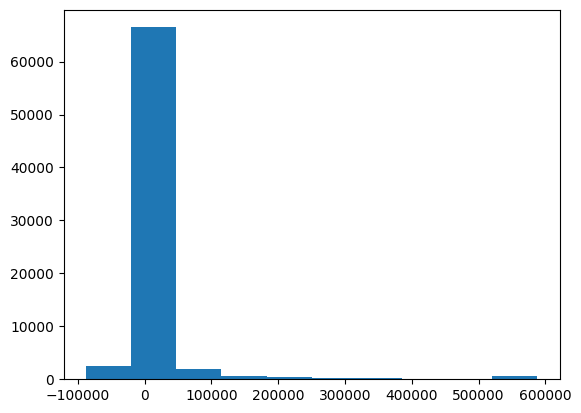

In [14]:
#  checkong target distribution

plt.hist(df['revenue'])

Next, we will begin data preprocessing. A ColumnTransformer is used to process categorical and numerical features separately. For categorical features, a OneHotEncoder is applied, while for numerical features, both RobustScaler and PowerTransformer are utilized.

The histogram reveals a highly skewed distribution of revenue, which can negatively impact model performance.

- For such data, transformation techniques can be applied. Classical options like logarithmic transformation and the more flexible Box-Cox transformation are unsuitable because they cannot handle negative values, and our dataset includes negative revenue values.
- The Yeo-Johnson transformation, however, extends normalization capabilities to any range of values.
- The features exhibit distributions similar to the target variable (also highly skewed with rare large values). Therefore, both the features and the target variable require transformation.

I will transform the numerical features and then analyze the distribution of the target variable before and after the transformation.

In [3]:
df_transformed = df.copy()

numeric_features = [
    'used_promo', 'first_bet_sum', 'm_win_cnt_bet', 'm_lose_cnt_bet', 
    'm_turnover', 'm_revenue', 'm_sum_dep', 'm_sum_out', 'm_cnt_dep', 
    'max_wins', 'first_day', 'fbt_turnover'
]

power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
df_transformed[numeric_features] = power_transformer.fit_transform(df_transformed[numeric_features])

NameError: name 'PowerTransformer' is not defined

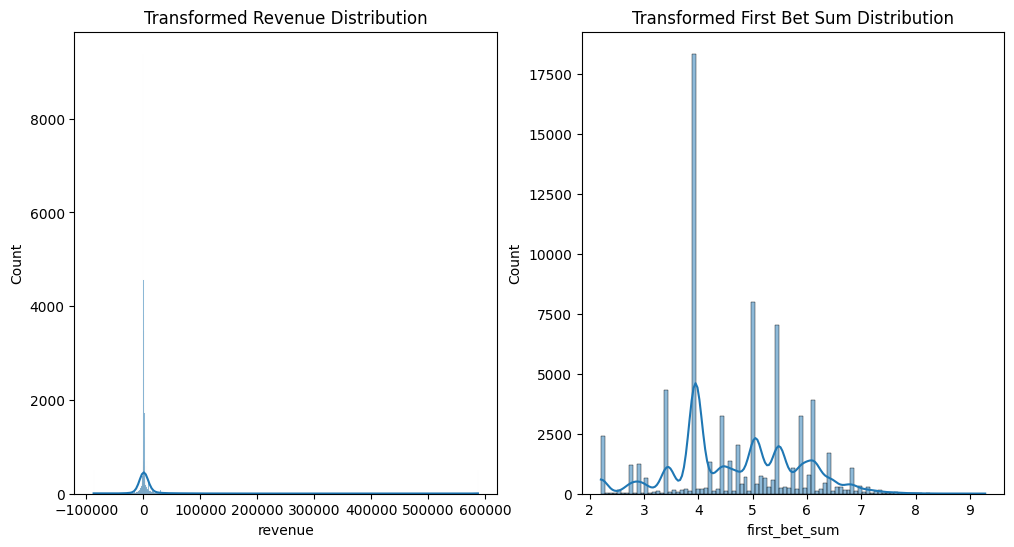

In [ ]:
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(df_transformed['revenue'], kde=True)
plt.title('Transformed Revenue Distribution')

# Transformed distribution
plt.subplot(1, 2, 2)
sns.histplot(df_transformed['revenue'], kde=True)
plt.title('Transformed First Bet Sum Distribution')

plt.show()

Next, we will create a pipeline to train various classifiers. Among them, we will select the one that delivers the best performance on our data.

In [31]:
categorical_features = ['reg_platform', 'used_promo']
numerical_features = ['first_bet_sum', 'm_turnover', 'm_revenue', 'm_sum_dep', 'max_wins']

# Proprocessor includes  RobustScaler, OneHotEncoder, PowerTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', RobustScaler()), 
            ('power', PowerTransformer(method='yeo-johnson'))
        ]), numerical_features),  # Numerical: RobustScaler + PowerTransformer
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # Categorical: OneHotEncoder
    ]
)

In [32]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # final classificator
])

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [34]:
# Separating the features and the target variable, while also removing the "revenue_180" column from the features, as it was used to assign the class labels.
X = df.drop(columns=['revenue', 'revenue_class'])
y = df['revenue_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# hyperparams grid
param_grid = [
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, 30]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1]
    }
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best parameters: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.8779840833098902


Saving model and preprocessor for future use

In [57]:
with open('preprocessor_class.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [ ]:
with open('best_classifier_pipeline.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

Slicing dataset with 1st class revenue clients for regression model

In [ ]:
class_0_df = df[df['revenue_class'] == 1]
class_0_df = class_0_df.drop(columns=['revenue_class'])
class_0_df.to_csv('class_1_df.csv', index=False)